# Modelling infrastructure exposure and risk

This notebook forms the basis of "Hands-On 6" in the CCG course.

It uses the road network and flood dataset extracted in the previous tutorial.

1. Exposure - overlay sample flood extent with the network and estimate flood depth of exposure
2. Vulnerability - assume depth-damage curve (fragility curve) for the road and
   - show how the exposure is translated to damage
   - create a table with probability, flood depth, length exposed, fragility, cost/km, direct damage
4. Risk - show a risk calculation on the table and generate the result
5. Future risk - repeat with climate projections and compare with baseline

By the end of this tutorial you should be able to:
* Assess direct damage and indirect disruptions to infrastructure assets
* Apply the risk calculation to understand how to generate loss-probability curves
* Show how different flood hazards introduce uncertainty in risk estimations

In [1]:
# Imports from Python standard library
import os
from pathlib import Path

# see https://docs.python.org/3/library/glob.html
from glob import glob

# Imports from other Python packages
import geopandas as gpd

# numpy is used by pandas and geopandas to store data in efficient arrays
# we use it in this notebook to help with trapezoidal integration
# see https://numpy.org/
import numpy as np
import pandas as pd

# seaborn helps produce more complex plots
# see https://seaborn.pydata.org/
import seaborn as sns

from scipy.integrate import simpson

import snail.damages
import snail.intersection
import snail.io

from pyproj import Geod

# tqdm lets us show progress bars (and تقدّم means "progress" in Arabic)
# see https://tqdm.github.io/
from tqdm.notebook import tqdm

Change this to point to your data folder as in the previous tutorial:

In [2]:
data_folder = Path("../data")

## 1. Exposure


List all the hazard files in the `flood_layer` folder:

In [3]:
hazard_files = sorted(glob(str(data_folder / "flood_layer/gha/wri_aqueduct_version_2/*.tif")))
len(hazard_files)

380

Read in roads again, then do intersections against all hazard scenarios.

In [4]:
roads_file = data_folder / "GHA_OSM_roads.gpkg"
roads = gpd.read_file(
    roads_file, layer="edges"
)
roads.head(2)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,236.526837,"LINESTRING (-0.17544 5.60550, -0.17418 5.60555..."
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10683,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)"


In [5]:
# split roads along hazard data grid

# TODO top-level "overlay_rasters"
# TODO for vector in vectors / for raster in rasters "overlay_raster"

# helper to read all, check if any are different
transform, bands = snail.io.read_raster_metadata(hazard_files[0])

# push into split_linestrings, flag to disable
prepared = snail.intersection.prepare_linestrings(roads)

flood_intersections = snail.intersection.split_linestrings(prepared, transform)

# push into split_linestrings
flood_intersections = snail.intersection.apply_indices(flood_intersections, transform)

raster_data: dict[str, pd.Series] = {}
# associate hazard data (flood depths) with split roads
for hazard_file in tqdm(hazard_files):
    key = os.path.basename(hazard_file).replace(".tif", "")
    raster_data[key] = snail.io.associate_raster_file(flood_intersections, hazard_file)

raster_data = pd.DataFrame(raster_data)
flood_intersections = pd.concat([flood_intersections, raster_data], axis="columns")


# calculate the length of each stretch of road
# don't include in snail wrapper top-level function
geod = Geod(ellps="WGS84")
flood_intersections["length_m"] = flood_intersections.geometry.apply(geod.geometry_length)

  0%|          | 0/380 [00:00<?, ?it/s]

In [6]:
# save to file
output_file = os.path.join(
    data_folder,
    "results",
    str(roads_file.name).replace(".gpkg", "_edges___exposure.geoparquet"),
)

flood_intersections.to_parquet(output_file)

In [7]:
flood_intersections.columns

Index(['osm_id', 'road_type', 'name', 'id', 'from_id', 'to_id', 'length_m',
       'geometry', 'split', 'index_i',
       ...
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2050_rp01000-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00002-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00005-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00010-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00025-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00050-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00100-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00250-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00500-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000-gha'],
      dtype='object', length=391)

In [8]:
data_cols = [col for col in flood_intersections.columns if "wri" in col]

In [9]:
# find any max depth and filter > 0
all_intersections = flood_intersections[flood_intersections[data_cols].max(axis=1) > 0]
# subset columns
all_intersections = all_intersections.drop(columns=[
    'osm_id', 'name', 'from_id', 'to_id', 'geometry', 'index_i', 'index_j'
])
# melt and check again for depth
all_intersections = all_intersections.melt(id_vars=['id', 'split', 'road_type', 'length_m'], value_vars=data_cols, var_name='key', value_name='depth_m') \
    .query('depth_m > 0')
all_intersections

,id,split,road_type,length_m,key,depth_m
491,roade_1432,6,tertiary,923.491197,wri_aqueduct-version_2-inuncoast_historical_wt...,0.518035
492,roade_1432,7,tertiary,926.689713,wri_aqueduct-version_2-inuncoast_historical_wt...,3.084949
493,roade_1432,8,tertiary,932.947555,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355
494,roade_1432,9,tertiary,552.000717,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324
506,roade_1459,4,primary,936.085067,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396
...,...,...,...,...,...,...
2104582,roade_15663,0,tertiary,390.592736,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,10.100431
2104583,roade_15663,1,tertiary,1003.487921,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,15.260432
2104584,roade_15663,2,tertiary,439.101808,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,18.910431
2104585,roade_15663,3,tertiary,491.119181,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,21.370432


In [10]:
river = all_intersections[all_intersections.key.str.contains('inunriver')]
coast = all_intersections[all_intersections.key.str.contains('inuncoast')]

coast_keys = coast.key.str.extract(r'wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<sub>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha')
coast = pd.concat([coast, coast_keys], axis=1)
river_keys = river.key.str.extract(r'wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<gcm>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha')
river = pd.concat([river, river_keys], axis=1)

In [11]:
coast.rp = coast.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
coast

,id,split,road_type,length_m,key,depth_m,hazard,rcp,sub,epoch,rp
491,roade_1432,6,tertiary,923.491197,wri_aqueduct-version_2-inuncoast_historical_wt...,0.518035,inuncoast,historical,wtsub,2030,1.5
492,roade_1432,7,tertiary,926.689713,wri_aqueduct-version_2-inuncoast_historical_wt...,3.084949,inuncoast,historical,wtsub,2030,1.5
493,roade_1432,8,tertiary,932.947555,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355,inuncoast,historical,wtsub,2030,1.5
494,roade_1432,9,tertiary,552.000717,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324,inuncoast,historical,wtsub,2030,1.5
506,roade_1459,4,primary,936.085067,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396,inuncoast,historical,wtsub,2030,1.5
...,...,...,...,...,...,...,...,...,...,...,...
555235,roade_15422,0,secondary,607.313815,wri_aqueduct-version_2-inuncoast_rcp8p5_wtsub_...,0.528029,inuncoast,rcp8p5,wtsub,2080,1000.0
555236,roade_15422,1,secondary,434.097962,wri_aqueduct-version_2-inuncoast_rcp8p5_wtsub_...,2.263576,inuncoast,rcp8p5,wtsub,2080,1000.0
555237,roade_15422,2,secondary,166.758106,wri_aqueduct-version_2-inuncoast_rcp8p5_wtsub_...,2.231466,inuncoast,rcp8p5,wtsub,2080,1000.0
555238,roade_15423,0,secondary,990.988389,wri_aqueduct-version_2-inuncoast_rcp8p5_wtsub_...,2.231466,inuncoast,rcp8p5,wtsub,2080,1000.0


In [12]:
# river.rp = river.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
river.gcm = river.gcm.str.replace("0", "")
river

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp
560853,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005
560855,roade_126,0,trunk,522.694931,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
560856,roade_127,0,trunk,54.297481,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
560857,roade_128,0,trunk,215.621077,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
560858,roade_128,1,trunk,860.230257,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
...,...,...,...,...,...,...,...,...,...,...,...
2104582,roade_15663,0,tertiary,390.592736,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,10.100431,inunriver,rcp8p5,MIROC-ESM-CHEM,2080,01000
2104583,roade_15663,1,tertiary,1003.487921,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,15.260432,inunriver,rcp8p5,MIROC-ESM-CHEM,2080,01000
2104584,roade_15663,2,tertiary,439.101808,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,18.910431,inunriver,rcp8p5,MIROC-ESM-CHEM,2080,01000
2104585,roade_15663,3,tertiary,491.119181,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-...,21.370432,inunriver,rcp8p5,MIROC-ESM-CHEM,2080,01000


Summarise total length of roads exposed to depth 2m or greater river flooding, under different return periods and climate scenarios:


In [49]:
summary = (
    river[river.depth_m >= 2.0].drop(columns=["id", "split", "road_type", "key"])
    .groupby(["hazard", "rcp", "gcm", "epoch", "rp"])
    .sum()
    .drop(columns=["depth_m"])
)
summary

length_m  paved  \
hazard    rcp        gcm       epoch rp                            
inunriver historical WATCH     1980  00005  296741.901017    361   
                                     00010  466942.878245    530   
                                     00025  546932.078938    621   
                                     00050  586574.089078    653   
                                     00100  612500.807552    679   
...                                                   ...    ...   
          rcp8p5     NorESM1-M 2080  00050  327054.369103    409   
                                     00100  382803.299076    474   
                                     00250  438718.185750    541   
                                     00500  519807.758720    639   
                                     01000  585133.300645    685   

                                                                                         kind  \
hazard    rcp        gcm       epoch rp                                                         
inunriver historical WATCH     1980  00005  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00010  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00025  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00050  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00100  paved_four_lanepaved_four_lanepaved_four_lanep...   
...                                                                                       ...   
          rcp8p5     NorESM1-M 2080  00050  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00100  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00250  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     00500  paved_four_lanepaved_four_lanepaved_four_lanep...   
                                     01000  paved_four_lanepaved_four_lanepaved_four_lanep...   

                                            cost_usd_per_km  \
hazard    rcp        gcm       epoch rp                       
inunriver historical WATCH     1980  00005        626954500   
                                     00010        954077840   
                                     00025       1132144640   
                                     00050       1194283920   
                                     00100       1239107140   
...                                                     ...   
          rcp8p5     NorESM1-M 2080  00050        694960240   
                                     00100        816689220   
                                     00250        974668020   
                                     00500       1147681060   
                                     01000       1266707680   

                                            proportion_damaged    damage_usd  
hazard    rcp        gcm       epoch rp                                       
inunriver historical WATCH     1980  00005          270.740477  2.731012e+08  
                                     00010          428.922085  4.122993e+08  
                                     00025          494.482708  4.964031e+08  
                                     00050          530.637328  5.274065e+08  
                                     00100          558.647820  5.483137e+08  
...                                                        ...           ...  
          rcp8p5     NorESM1-M 2080  00050          291.031539  3.236604e+08  
                                     00100          345.604948  3.733383e+08  
                                     00250          401.152554  4.383120e+08  
                                     00500          464.839873  5.250936e+08  
                                     01000          516.541794  5.768648e+08  

[208 rows x 6 columns]

Plot exposure against return period, with separate plot areas for each Representative Concentration Pathway (RCP), and different colours for the different Global Climate Models (GCM): 

In [54]:
plot_data = summary.reset_index()
plot_data = plot_data[plot_data.epoch.isin(['1980', '2080'])]
plot_data.rp = plot_data.rp.apply(lambda rp: int(rp.lstrip("0")))
plot_data["probability"] = 1 / plot_data.rp
plot_data

,hazard,rcp,gcm,epoch,rp,length_m,paved,kind,cost_usd_per_km,proportion_damaged,damage_usd,probability
0,inunriver,historical,WATCH,1980,5,296741.901017,361,paved_four_lanepaved_four_lanepaved_four_lanep...,626954500,270.740477,2.731012e+08,0.200
1,inunriver,historical,WATCH,1980,10,466942.878245,530,paved_four_lanepaved_four_lanepaved_four_lanep...,954077840,428.922085,4.122993e+08,0.100
2,inunriver,historical,WATCH,1980,25,546932.078938,621,paved_four_lanepaved_four_lanepaved_four_lanep...,1132144640,494.482708,4.964031e+08,0.040
3,inunriver,historical,WATCH,1980,50,586574.089078,653,paved_four_lanepaved_four_lanepaved_four_lanep...,1194283920,530.637328,5.274065e+08,0.020
4,inunriver,historical,WATCH,1980,100,612500.807552,679,paved_four_lanepaved_four_lanepaved_four_lanep...,1239107140,558.647820,5.483137e+08,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...
203,inunriver,rcp8p5,NorESM1-M,2080,50,327054.369103,409,paved_four_lanepaved_four_lanepaved_four_lanep...,694960240,291.031539,3.236604e+08,0.020
204,inunriver,rcp8p5,NorESM1-M,2080,100,382803.299076,474,paved_four_lanepaved_four_lanepaved_four_lanep...,816689220,345.604948,3.733383e+08,0.010
205,inunriver,rcp8p5,NorESM1-M,2080,250,438718.185750,541,paved_four_lanepaved_four_lanepaved_four_lanep...,974668020,401.152554,4.383120e+08,0.004
206,inunriver,rcp8p5,NorESM1-M,2080,500,519807.758720,639,paved_four_lanepaved_four_lanepaved_four_lanep...,1147681060,464.839873,5.250936e+08,0.002


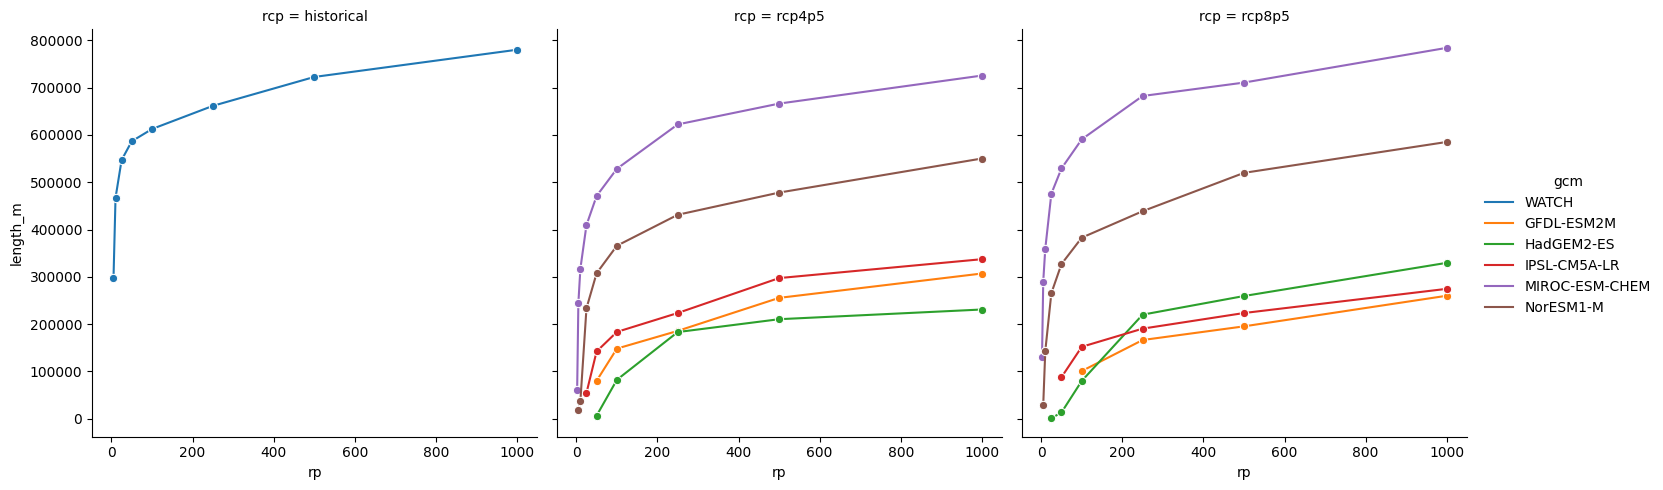

In [63]:
sns.relplot(
    data=plot_data,
    x="rp",
    y="length_m",
    hue="gcm",
    col="rcp",
    kind="line",
    marker="o"
)

## 2. Vulnerability

Set up fragility curve assumptions, where probability of damage (`pfail`) depends on whether a road is paved and the depth of flood it is exposed to. 

These assumptions are derived from Koks, E.E., Rozenberg, J., Zorn, C. et al. A global multi-hazard risk analysis of road and railway infrastructure assets. Nat Commun 10, 2677 (2019). https://doi.org/10.1038/s41467-019-10442-3, Figure S3, extrapolated to 2m and 3m depths. 

The analysis is likely to be highly sensitive to these assumptions, and this approach is strongly limited by the availability and quality of fragility data, as well as the assumption that fragility can be related to flood depth alone - flood water velocity would be an important factor in a more detailed vulnerability assessment. 

In [15]:
paved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame({"intensity": [0.0, 0.999999999, 1, 2, 3], "damage": [0.0, 0.0, 0.1, 0.3, 0.5]})
)
unpaved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame({"intensity": [0.0, 0.999999999, 1, 2, 3], "damage": [0.0, 0.0, 0.9, 1.0, 1.0]})
)
paved, unpaved

(<snail.damages.LinearDamageCurve at 0x7f1642a38970>,
 <snail.damages.LinearDamageCurve at 0x7f1643399990>)

(<Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>,
 <Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>)

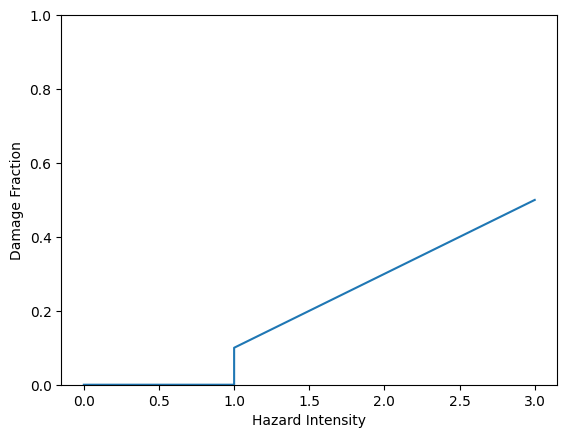

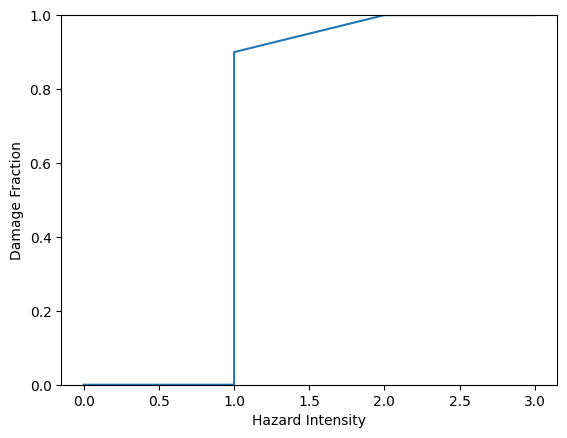

In [16]:
paved.plot(), unpaved.plot()

Set up cost assumptions. 

These are taken from Koks et al (2019) again, Table S8, construction costs to be assumed as an estimate of full rehabilitation after flood damage. 

Again the analysis is likely to be highly sensitive to these assumptions, which should be replaced by better estimates if available.

In [17]:
costs = pd.DataFrame(
    {
        "kind": ["paved_four_lane", "paved_two_lane", "unpaved"],
        "cost_usd_per_km": [3_800_000, 932_740, 22_780],
    }
)
costs

,kind,cost_usd_per_km
0,paved_four_lane,3800000
1,paved_two_lane,932740
2,unpaved,22780


Set up assumptions about which roads are paved or unpaved, and number of lanes.

In [18]:
sorted(river.road_type.unique())

['motorway',
 'primary',
 'primary_link',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link']

Assume all `tertiary` roads are unpaved, all others are paved.

In [19]:
river["paved"] = ~(river.road_type == "tertiary")

In [20]:
def kind(road_type):
    if road_type in ("trunk", "trunk_link", "motorway"):
        return "paved_four_lane"
    elif road_type in ("primary", "primary_link", "secondary"):
        return "paved_two_lane"
    else:
        return "unpaved"


river["kind"] = river.road_type.apply(kind)

In [21]:
river = river.merge(costs, on="kind")

Use the damage curve to estimate `proportion_damaged` for each exposed section.

In [22]:
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km
0,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000
1,roade_126,0,trunk,522.694931,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000


In [23]:
paved_depths = river.loc[river.paved, 'depth_m']
paved_damage = paved.damage_fraction(paved_depths)
river.loc[river.paved, 'proportion_damaged'] = paved_damage

unpaved_depths = river.loc[~river.paved, 'depth_m']
unpaved_damage = paved.damage_fraction(unpaved_depths)
river.loc[~river.paved, 'proportion_damaged'] = unpaved_damage

Finally estimate cost of rehabilitation for each exposed section

In [24]:
river["damage_usd"] = (
    river.length_m
    * river.cost_usd_per_km
    * 1e-3
)
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km,proportion_damaged,damage_usd
0,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.348708,9.753090e+05
1,roade_126,0,trunk,522.694931,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.000000,1.986241e+06


In [25]:
river.to_csv(
    os.path.join(data_folder, "results/inunriver_damages_rp.csv"), index=False
)

In [26]:
summary = (
    river
    .drop(columns=["id", "split", "length_m", "key", "depth_m", "paved", "kind", "cost_usd_per_km", "proportion_damaged"])
    .groupby(
        ["road_type",  "hazard", "rcp", "gcm", "epoch", "rp"]
    )
    .sum()
)
summary

damage_usd
road_type  hazard    rcp        gcm       epoch rp                 
motorway   inunriver historical WATCH     1980  00005  1.804435e+07
                                                00010  1.804435e+07
                                                00025  1.804435e+07
                                                00050  1.804435e+07
                                                00100  1.804435e+07
...                                                             ...
trunk_link inunriver rcp8p5     NorESM1-M 2080  00050  4.120193e+06
                                                00100  4.120193e+06
                                                00250  4.255795e+06
                                                00500  4.255795e+06
                                                01000  4.255795e+06

[2502 rows x 1 columns]

## 3. Risk

Calculate expected annual damages for each road under historical hazard.

Start by selecting only historical intersections, and keeping only the road ID, return period, and cost of rehabilitation if damaged.

In [27]:
historical = river[
    river.rcp == "historical"
][["id", "rp", "damage_usd"]]

Sum up the expected damage for each road, per return period, then pivot the table to create columns for each return period - now there is one row per road.

In [28]:
historical = (
    historical.groupby(["id", "rp"])
    .sum()
    .reset_index()
)
historical = historical.pivot(index="id", columns="rp").replace(
    float("NaN"), 0
)
historical.columns = [f"rp{int(rp)}" for _, rp in historical.columns]
historical.head(2)

,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000
id,,,,,,,,
roade_10003,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851
roade_10005,0.000000,0.000000,31770.854999,31770.854999,31770.854999,31770.854999,31770.854999,31770.854999


Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [29]:
def calculate_ead(df):
    rp_cols = sorted(list(df.columns), key=lambda col: 1/int(col.replace("rp", "")))
    rps = np.array([int(col.replace("rp", "")) for col in rp_cols])
    probabilities = 1 / rps
    rp_damages = df[rp_cols]
    return simpson(rp_damages, x=probabilities, axis=1)

historical["ead_usd"] = calculate_ead(historical)
historical.head(2)


,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000,ead_usd
id,,,,,,,,,
roade_10003,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851,254.692851,50.683877
roade_10005,0.000000,0.000000,31770.854999,31770.854999,31770.854999,31770.854999,31770.854999,31770.854999,1980.383295


In [30]:
historical.to_csv(
    os.path.join(data_folder, "results/inunriver_damages_ead__historical.csv")
)

## 4. Future risk

Calculate expected annual damages under each future scenario (for each global climate model and representative concentration pathway).

This follows the same method as for historical flooding above, with the added variables of climate model and rcp.

In [31]:
future = river[
    ["id", "rp", "rcp", "gcm", "epoch", "damage_usd"]
].copy()

Sum up the expected damage for each road, per return period, gcm and rcp

In [32]:
future = (
    future.groupby(["id", "rp", "rcp", "gcm", "epoch"])
    .sum()
    .reset_index()
)
future.head(2)

,id,rp,rcp,gcm,epoch,damage_usd
0,roade_10003,00002,rcp4p5,GFDL-ESM2M,2030,254.692851
1,roade_10003,00002,rcp4p5,GFDL-ESM2M,2050,254.692851


Pivot the table to create columns for each return period - now there is one row per road, gcm and rcp.

In [33]:
future = future.pivot(index=["id", "rcp", "gcm", "epoch"], columns="rp").replace(
    float("NaN"), 0
)
future.columns = [f"rp{int(rp)}" for _, rp in future.columns]
future.head(2)

rp2         rp5        rp10  \
id          rcp        gcm        epoch                                       
roade_10003 historical WATCH      1980     0.000000  254.692851  254.692851   
            rcp4p5     GFDL-ESM2M 2030   254.692851  254.692851  254.692851   

                                               rp25        rp50       rp100  \
id          rcp        gcm        epoch                                       
roade_10003 historical WATCH      1980   254.692851  254.692851  254.692851   
            rcp4p5     GFDL-ESM2M 2030   254.692851  254.692851  254.692851   

                                              rp250       rp500      rp1000  
id          rcp        gcm        epoch                                      
roade_10003 historical WATCH      1980   254.692851  254.692851  254.692851  
            rcp4p5     GFDL-ESM2M 2030   254.692851  254.692851  254.692851

Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [34]:
future["ead_usd"] = calculate_ead(future)

In [35]:
future.to_csv(os.path.join(data_folder, "results/inunriver_damages_ead.csv"))

Pick out an individual road by id, to spot check uncertainty:

In [36]:
future.loc["roade_10003"]

rp2         rp5        rp10  \
rcp        gcm            epoch                                       
historical WATCH          1980     0.000000  254.692851  254.692851   
rcp4p5     GFDL-ESM2M     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           HadGEM2-ES     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           IPSL-CM5A-LR   2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           MIROC-ESM-CHEM 2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           NorESM1-M      2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
rcp8p5     GFDL-ESM2M     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           HadGEM2-ES     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           IPSL-CM5A-LR   2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           MIROC-ESM-CHEM 2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           NorESM1-M      2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   

                                       rp25        rp50       rp100  \
rcp        gcm            epoch                                       
historical WATCH          1980   254.692851  254.692851  254.692851   
rcp4p5     GFDL-ESM2M     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           HadGEM2-ES     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           IPSL-CM5A-LR   2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           MIROC-ESM-CHEM 2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           NorESM1-M      2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
rcp8p5     GFDL-ESM2M     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.692851   
           HadGEM2-ES     2030   254.692851  254.692851  254.692851   
                          2050   254.692851  254.692851  254.692851   
                          2080   254.692851  254.692851  254.69

Summarise total expected annual (direct) damages, showing variation between climate models and representative concentration pathways.

In [46]:
summary = (
    future.reset_index()[["rcp", "gcm", "epoch", "ead_usd"]]
    .groupby(["rcp", "gcm", "epoch"])
    .sum()
    .reset_index()
)
summary.epoch = summary.epoch.astype(int)
summary

,rcp,gcm,epoch,ead_usd
0,historical,WATCH,1980,5.915943e+08
1,rcp4p5,GFDL-ESM2M,2030,6.486476e+08
2,rcp4p5,GFDL-ESM2M,2050,6.497956e+08
3,rcp4p5,GFDL-ESM2M,2080,6.380344e+08
4,rcp4p5,HadGEM2-ES,2030,6.692441e+08
5,rcp4p5,HadGEM2-ES,2050,6.523131e+08
6,rcp4p5,HadGEM2-ES,2080,5.908718e+08
7,rcp4p5,IPSL-CM5A-LR,2030,5.511756e+08
8,rcp4p5,IPSL-CM5A-LR,2050,5.352992e+08
9,rcp4p5,IPSL-CM5A-LR,2080,5.520599e+08


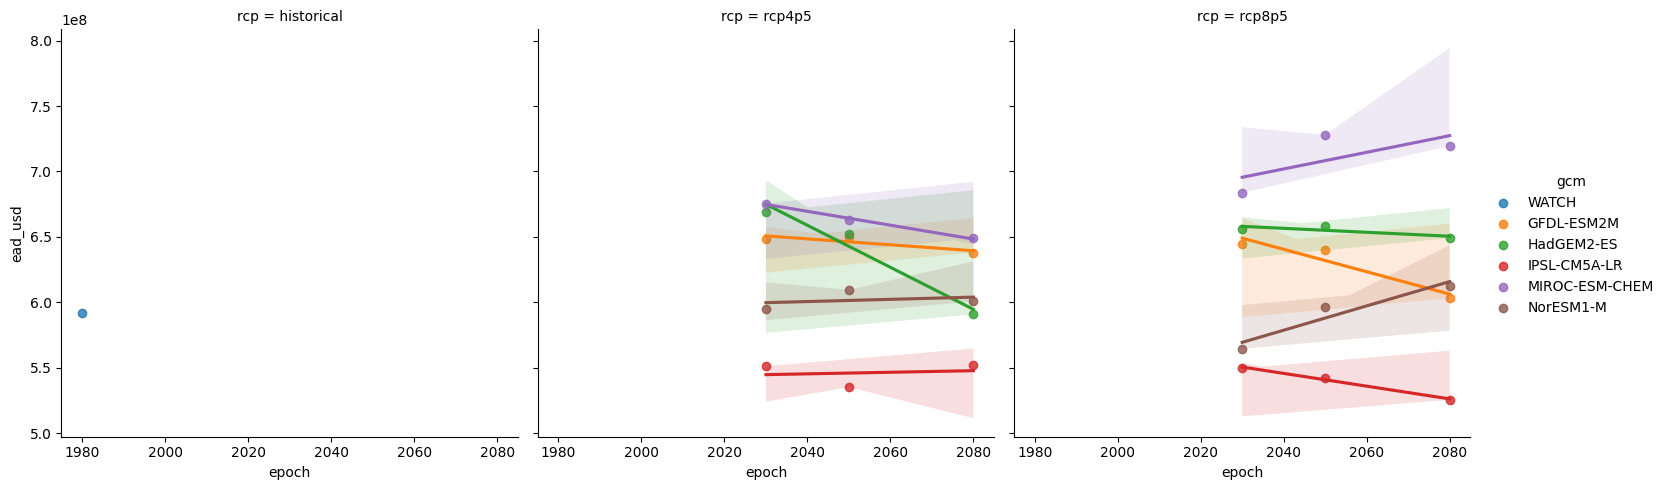

In [47]:
sns.lmplot(
    data=summary, col="rcp", x="epoch", y="ead_usd", hue="gcm", #fit_reg=False
)